# Import Packages

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Literal, Dict
import json

from dotenv import load_dotenv
import os

load_dotenv()

/home/nikhil/Documents/AgenticAI/PersonalAssistant/LightWeightAssistant/venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


True

In [2]:
# Constants
MODEL_NAME = "gemini-2.5-flash-lite"
TEMPERATURE = 0
MAX_RETRIES = 2
TIMEOUT = None
MAX_TOKENS = None

# Model Creation

In [3]:
llm = ChatGoogleGenerativeAI(
    model = MODEL_NAME,
    temperature = TEMPERATURE,
    max_tokens = MAX_TOKENS,
    timeout = TIMEOUT,
    max_retries = MAX_RETRIES
)

# Setup Tools

# Agent State

In [4]:
class AgentState(TypedDict):
    messages: List[str]
    user_query: str
    steps: List[Dict[str, str]]
    current_step: int
    current_node: str

# Node Creation

In [5]:
def new_state(state: AgentState, updated_state: Dict):
    new_state = {}

    new_state["messages"] = state["messages"]
    new_state["user_query"] = state["user_query"]
    new_state["steps"] = state["steps"]
    new_state["current_step"] = state["current_step"]
    new_state["current_node"] = state["current_node"]

    for key in updated_state.keys():
        new_state[key] = updated_state[key]

    return new_state


In [6]:
# Refresh State Node
REFRESH_STATE_NODE = "Refresh State"

def refresh_state(state: AgentState):
    updated_state = {
        "user_query": "",
        "steps": [],
        "current_step": 0,
        "current_node": REFRESH_STATE_NODE
    }

    return new_state(state, updated_state)

In [7]:
# Input Query Node
INPUT_QUERY_NODE = "Input Query"

def input_query(state: AgentState):
    # user_input = input("User Query : ")
    user_input = "Hey buddy. Help me lauch vscode. also would like to know how jira works. Also how about visiting YouTube for some relaxing song. Best suggest me some songs to listen to.Then maybe just quit the conversation"
    
    messages = state["messages"]
    messages.append(("user", user_input))

    updated_state = {
        "user_query": user_input,
        "current_node": INPUT_QUERY_NODE,
        "messages": messages
    }
    return new_state(state, updated_state)

In [8]:
# Instruction Breakdown Node
INSTRUCTION_BREAKDOWN_NODE = "BreakDown Instructions"

INSTRUCTION_BREAKDOWN_PROMPT = """
    You are a great Supervisor. You have few interns working under you.
    They can only handle one task at a time. 
    So your job is to receive a command from user and identify multiple instructions given in it.
    And then create a list of instructions from it. 

    You will have access to previous conversation with user.
    Based on that you can also decide an instruction to greet the user.

    List of Interns working under you :
        - Greet -> Greets the user
        - Sage -> Answers the question asked
        - LaunchApplication -> Launches the mentioned application
        - OpenWebsite -> Opens the mentioned website
        - Quit -> Ends the conversation
    
    RESPONSE_FORMAT:
        [
            {
                "Node": "Greet", #Name of the intern to handle instruction
                "Instruction": "Greet the user enthusiastically" #Instruction given to the intern
            }
        ]
        
    Strict Rules:
        - Response should strictly follow mentioned RESPONSE_FORMAT
        - Response should be a json parsable
        - Instructions should be ordered so that independent ones come first
        - If quit action is involved in instructions, then it should come at last in the list
        
    Examples:
        1.  User Command : Hey buddy, how are you doing? I want you to help me with opening vscode for me. And also what is blockchain
            Response :  [
                            {
                                "Node": "Greet",
                                "Instruction": "Hey buddy, how are you doing?"
                            },
                            {
                                "Node": "LaunchApplication",
                                "Instruction": "Launch vscode"
                            },
                            {
                                "Node": "Sage",
                                "Instruction": "What is blockchain?"
                            }
                        ]
        2.  User Command : Really having hard time figuring out how jira works. Please help me. Also this will be end of our conversation
            Response :  [
                            {
                                "Node": "Sage",
                                "Instruction": "Explain how jira works"
                            },
                            {
                                "Node": "Quit",
                                "Instruction": "End Conversation"
                            }
                        ]
                        
"""

def breakdown_instructions(state: AgentState):
    # call llm to breakdown instructions in parts
    llm_messages = [
        ("system", INSTRUCTION_BREAKDOWN_PROMPT),
        ("user", state["user_query"])
    ]

    response = llm.invoke(llm_messages)

    try:
        parsable_content = response.content.removeprefix("```json").removesuffix("```")
        # parse the steps
        new_steps = json.loads(parsable_content)

        print("PARSED STEPS : ")
        for step in new_steps:
            print("-" * 40)
            print(f"Node : {step['Node']}")
            print(f"Instruction : {step['Instruction']}")

    except json.decoder.JSONDecodeError:
        print(f"Response Not in correct format at {INSTRUCTION_BREAKDOWN_NODE}")
        print("-" * 40)
        print(response.content)
        print("-" * 40)

    updated_state = {
        "steps": new_steps,
        "current_node": INSTRUCTION_BREAKDOWN_NODE
    }
    return new_state(state, updated_state)

In [9]:
# Steps Iterator Node
STEPS_ITERATOR_NODE = "Steps Iterator"

def iterate_steps(state: AgentState):
    previous_step = state["current_step"]

    updated_state = {
        "current_step": previous_step+1,
        "current_node": STEPS_ITERATOR_NODE
    }
    return new_state(state, updated_state)

In [10]:
# Greet Node
GREET_NODE = "Greet"

GREET_USER_PROMPT = """
    You are a cheerful but respectable person in charge of greeting the user.
    You response should only be saying greetings to the user.
    Any other responses like what can I do for you? or tell me whats happening are strictly prohabited.
"""

def greet_user(state: AgentState):
    current_step_num = state["current_step"]
    instruction = state["steps"][current_step_num-1]["Instruction"]

    llm_messages = [
        ("system", GREET_USER_PROMPT),
        ("user", instruction)
    ]

    response = llm.invoke(llm_messages)

    print("=" * 40)
    print(f"AI : {response.content}")
    print("=" * 40)

    messages = state["messages"]
    messages.append(("ai", response.content))

    updated_state = {
        "messages": messages,
        "current_node": GREET_NODE
    }
    return new_state(state, updated_state)

In [11]:
# Question Answering Node
QUESTION_ANSWERING_NODE = "Sage"

QUESTION_ANSWERING_PROMPT = """
    You are considered an all-knowing sage of the system. User turns to you
    to receive some good hints that may help them in their work.

    Your task is to answer user's question while also suggesting keywords to search for.
    If you know some sites which can be helpful, then please do mention them.

    STRICT RULES:
        - Keep responses short unless user has asked for detailed information

"""

def answer_question(state: AgentState):
    current_step_num = state["current_step"]
    instruction = state["steps"][current_step_num-1]["Instruction"]

    llm_messages = [
        ("system", QUESTION_ANSWERING_PROMPT),
        ("user", instruction)
    ]

    response = llm.invoke(llm_messages)

    print("=" * 40)
    print(f"AI : {response.content}")
    print("=" * 40)

    messages = state["messages"]
    messages.append(("ai", response.content))

    updated_state = {
        "messages": messages,
        "current_node": QUESTION_ANSWERING_PROMPT
    }
    return new_state(state, updated_state)


In [12]:
# Application Launch Node
LAUNCH_APPLICATION_NODE = "LaunchApplication"

LAUNCH_APPLICATION_PROMPT = """
    You are an expert at helping users launch application by executing commands in terminal.

    STRICT RULES:
        - commands should be executable in an Ubuntu terminal
        - If there are multiple commands, then modify them to be executable in single command line
        - Only return command(s). No extra response should be given
"""

def launch_application(state: AgentState):
    current_step_num = state["current_step"]
    instruction = state["steps"][current_step_num-1]["Instruction"]

    llm_messages = [
        ("system", LAUNCH_APPLICATION_PROMPT),
        ("user", instruction)
    ]

    response = llm.invoke(llm_messages)

    print("=" * 40)
    print(f"AI : {response.content}")
    print("=" * 40)

    messages = state["messages"]
    messages.append(("ai", response.content))

    updated_state = {
        "messages": messages,
        "current_node": LAUNCH_APPLICATION_NODE
    }
    return new_state(state, updated_state)

In [13]:
# Open Website Node
OPEN_WEBSITE_NODE = "OpenWebsite"

OPEN_WEBSITE_PROMPT = """
    You are an expert at directing users to the correct url of a website user is searching for.

    STRICT RULES:
        - response should only contain url of the website. No other words
        - If not aware of the url, then share google search link with the websites hint
"""

def open_website(state: AgentState):
    current_step_num = state["current_step"]
    instruction = state["steps"][current_step_num-1]["Instruction"]

    llm_messages = [
        ("system", OPEN_WEBSITE_PROMPT),
        ("user", instruction)
    ]

    response = llm.invoke(llm_messages)

    print("=" * 40)
    print(f"AI : {response.content}")
    print("=" * 40)

    messages = state["messages"]
    messages.append(("ai", response.content))

    updated_state = {
        "messages": messages,
        "current_node": OPEN_WEBSITE_NODE
    }
    return new_state(state, updated_state)

In [14]:
# Quit Node
QUIT_NODE = "Quit"

def quit_conversation(state: AgentState):
    updated_state = {
        "current_node": QUIT_NODE
    }
    return new_state(state, updated_state)

In [15]:
# Summarize Conversation Node
SUMMARIZE_CONVERSATION_NODE = "Summarize Conversation"

def summarize_conversation(state: AgentState):
    updated_state = {
        "current_node": SUMMARIZE_CONVERSATION_NODE
    }
    return new_state(state, updated_state)


In [16]:
# Next Step Checker Node
HAS_NEXT_STEP_NODE = "Has Next Step"

def shall_go_to_next_step(state: AgentState):
    updated_state = {
        "current_node": HAS_NEXT_STEP_NODE
    }
    return new_state(state, updated_state)

In [17]:
workflow = StateGraph(AgentState)

## Add Nodes

In [18]:
workflow.add_node(REFRESH_STATE_NODE, refresh_state)
workflow.add_node(INPUT_QUERY_NODE, input_query)
workflow.add_node(INSTRUCTION_BREAKDOWN_NODE, breakdown_instructions)
workflow.add_node(STEPS_ITERATOR_NODE, iterate_steps)
workflow.add_node(GREET_NODE, greet_user)
workflow.add_node(QUESTION_ANSWERING_NODE, answer_question)
workflow.add_node(LAUNCH_APPLICATION_NODE, launch_application)
workflow.add_node(OPEN_WEBSITE_NODE, open_website)
workflow.add_node(QUIT_NODE, quit_conversation)
workflow.add_node(SUMMARIZE_CONVERSATION_NODE, summarize_conversation)
workflow.add_node(HAS_NEXT_STEP_NODE, shall_go_to_next_step)

## Add Edges

In [19]:
workflow.add_edge(START, REFRESH_STATE_NODE)
workflow.add_edge(REFRESH_STATE_NODE, INPUT_QUERY_NODE)
workflow.add_edge(INPUT_QUERY_NODE, INSTRUCTION_BREAKDOWN_NODE)
workflow.add_edge(INSTRUCTION_BREAKDOWN_NODE, STEPS_ITERATOR_NODE)

workflow.add_edge(GREET_NODE, HAS_NEXT_STEP_NODE)
workflow.add_edge(QUESTION_ANSWERING_NODE, HAS_NEXT_STEP_NODE)
workflow.add_edge(LAUNCH_APPLICATION_NODE, HAS_NEXT_STEP_NODE)
workflow.add_edge(OPEN_WEBSITE_NODE, HAS_NEXT_STEP_NODE)

workflow.add_edge(QUIT_NODE, SUMMARIZE_CONVERSATION_NODE)
workflow.add_edge(SUMMARIZE_CONVERSATION_NODE, END)

# Define Conditional Edges

In [20]:
def decide_next_step_node(state: AgentState) -> Literal["Greet", "Sage", "LaunchApplication", "OpenWebsite", "Quit"]:
    current_step_num = state["current_step"]
    current_step_node = state["steps"][current_step_num-1]["Node"]

    print('-' * 40)
    print(f"Deciding on node to be called : {current_step_node}")
    print("-" * 40)

    if current_step_node == GREET_NODE:
        return GREET_NODE
    elif current_step_node == QUESTION_ANSWERING_NODE:
        return QUESTION_ANSWERING_NODE
    elif current_step_node == LAUNCH_APPLICATION_NODE:
        return LAUNCH_APPLICATION_NODE
    elif current_step_node == OPEN_WEBSITE_NODE:
        return OPEN_WEBSITE_NODE
    return QUIT_NODE

In [21]:
def shall_continue_iteration(state: AgentState) -> Literal["Refresh State", "Steps Iterator"]:
    current_step_num = state["current_step"]
    steps_num = len(state["steps"])

    if current_step_num >= steps_num:
        return REFRESH_STATE_NODE
    return STEPS_ITERATOR_NODE

In [22]:
# Decide on which node should handle current step
workflow.add_conditional_edges(
    STEPS_ITERATOR_NODE, 
    decide_next_step_node,
    {
        GREET_NODE: GREET_NODE,
        QUESTION_ANSWERING_NODE: QUESTION_ANSWERING_NODE,
        LAUNCH_APPLICATION_NODE: LAUNCH_APPLICATION_NODE,
        OPEN_WEBSITE_NODE: OPEN_WEBSITE_NODE,
        QUIT_NODE: QUIT_NODE
    }
)

# Decide on whether to continue step iteration or await for user input
workflow.add_conditional_edges(
    HAS_NEXT_STEP_NODE,
    shall_continue_iteration,
    {
        REFRESH_STATE_NODE: REFRESH_STATE_NODE,
        STEPS_ITERATOR_NODE: STEPS_ITERATOR_NODE
    }
)

# Compile the graph along with memory settings

In [23]:
assistant = workflow.compile()

# Draw the graph

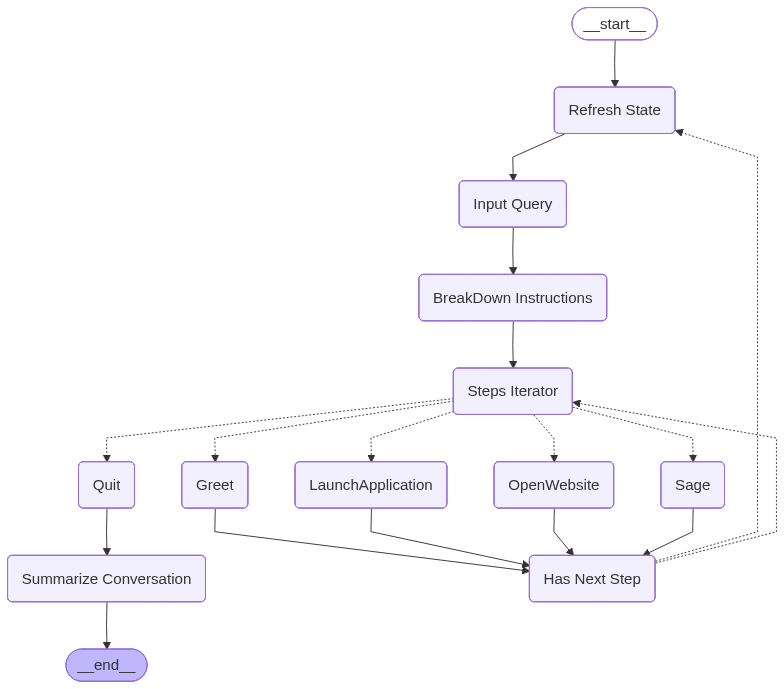

In [24]:
from IPython.display import Image

Image(
    assistant.get_graph().draw_mermaid_png()
)

# Agent Execution

In [25]:
# Define initial state

initial_state = {
    "messages": [],
    "user_query": "",
    "steps": [],
    "current_step": 0,
    "current_node": ""
}

In [26]:
final_state = assistant.invoke(initial_state)

PARSED STEPS : 
----------------------------------------
Node : Greet
Instruction : Hey buddy.
----------------------------------------
Node : LaunchApplication
Instruction : Launch vscode
----------------------------------------
Node : Sage
Instruction : How does Jira work?
----------------------------------------
Node : OpenWebsite
Instruction : Visit YouTube for some relaxing songs.
----------------------------------------
Node : Sage
Instruction : Suggest some songs to listen to.
----------------------------------------
Node : Quit
Instruction : Quit the conversation.
----------------------------------------
Deciding on node to be called : Greet
----------------------------------------
AI : Hello there!
----------------------------------------
Deciding on node to be called : LaunchApplication
----------------------------------------
AI : ```bash
code
```
----------------------------------------
Deciding on node to be called : Sage
----------------------------------------
AI : Jira 

In [27]:
print("=" * 40)
print("\nFinal State : ")
print("=" * 40)

print("\n Messages : ")
print("-" * 40)
for message in final_state["messages"]:
    print(message)


Final State : 

 Messages : 
----------------------------------------
('user', 'Hey buddy. Help me lauch vscode. also would like to know how jira works. Also how about visiting YouTube for some relaxing song. Best suggest me some songs to listen to.Then maybe just quit the conversation')
('ai', 'Hello there!')
('ai', '```bash\ncode\n```')
('ai', 'Jira is a project management tool used for tracking bugs, issues, and other tasks. It allows teams to plan, track, and release software.\n\nHere are some keywords to search for:\n\n*   **Jira workflow**\n*   **Jira boards (Scrum, Kanban)**\n*   **Jira issues and epics**\n*   **Jira reporting**\n\nHelpful sites:\n\n*   **Atlassian Jira Documentation:** [https://confluence.atlassian.com/jira/jira-documentation-home-201890900.html](https://confluence.atlassian.com/jira/jira-documentation-home-201890900.html)\n*   **Atlassian Blog:** [https://www.atlassian.com/blog](https://www.atlassian.com/blog)')
('ai', 'https://www.youtube.com/')
('ai', 'To g